<a href="https://colab.research.google.com/github/MahdiFaourr/MahdiFaourr/blob/main/Emotions_from_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
!pip install gradio==3.14.0

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D,Input,GlobalAveragePooling2D,
from tensorflow.keras.metrics import Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import opendatasets as od
from keras.callbacks import ModelCheckpoint
import os
import shutil
import gradio as gr
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset from kaggle
od.download("https://www.kaggle.com/datasets/sanidhyak/human-face-emotions")

In [ ]:
root_dir="/content/human-face-emotions/data"
classes=['Angry','Happy','Sad']
for class_name in classes:
  train_dir=os.path.join(root_dir,"train",class_name)
  valid_dir=os.path.join(root_dir,"valid",class_name)
  os.makedirs(train_dir,exist_ok=True)
  os.makedirs(valid_dir,exist_ok=True)

In [ ]:
Angry_images=[image for image in os.listdir(os.path.join(root_dir,'Angry'))]
train_Angry_images,valid_Angry_images=train_test_split(Angry_images,test_size=0.2,random_state=42)
for img in train_Angry_images:
  source_path=os.path.join(root_dir,'Angry',img)
  destination_path=os.path.join(root_dir,"train",'Angry',img)
  shutil.move(source_path,destination_path)
for img in valid_Angry_images:
  source_path=os.path.join(root_dir,'Angry',img)
  destination_path=os.path.join(root_dir,"valid",'Angry',img)
  shutil.move(source_path,destination_path)

In [ ]:
Happy_images=[image for image in os.listdir(os.path.join(root_dir,'Happy'))]
train_Happy_images,valid_Happy_images=train_test_split(Happy_images,test_size=0.2,random_state=42)
for img in train_Happy_images:
  source_path=os.path.join(root_dir,'Happy',img)
  destination_path=os.path.join(root_dir,"train",'Happy',img)
  shutil.move(source_path,destination_path)
for img in valid_Happy_images:
  source_path=os.path.join(root_dir,'Happy',img)
  destination_path=os.path.join(root_dir,"valid",'Happy',img)
  shutil.move(source_path,destination_path)

In [ ]:
Sad_images=[image for image in os.listdir(os.path.join(root_dir,'Sad'))]
train_Sad_images,valid_Sad_images=train_test_split(Sad_images,test_size=0.2,random_state=42)
for img in train_Sad_images:
  source_path=os.path.join(root_dir,'Sad',img)
  destination_path=os.path.join(root_dir,"train",'Sad',img)
  shutil.move(source_path,destination_path)
for img in valid_Sad_images:
  source_path=os.path.join(root_dir,'Sad',img)
  destination_path=os.path.join(root_dir,"valid",'Sad',img)
  shutil.move(source_path,destination_path)

In [ ]:
# Define the parameters for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define the directory containing your image data
train_dir = "/content/human-face-emotions/data/train"
valid_dir= "/content/human-face-emotions/data/valid"

# Create an ImageDataGenerator for the training data
train_generator =datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical'
)

valid_generator=datagen.flow_from_directory(
    valid_dir,
    batch_size=32,
    class_mode='categorical'
)


Found 210 images belonging to 3 classes.
Found 54 images belonging to 3 classes.


In [ ]:
# Load MobileNetV1 base model without top (fully connected) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Create a Sequential model
model = Sequential()

# Add the MobileNetV1 base model to the Sequential model
model.add(base_model)
# Set MobileNetV1 layers as non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add GlobalAveragePooling2D layer to reduce spatial dimensions
model.add(GlobalAveragePooling2D())

# Add custom dense layers for classification
model.add(Dense(220, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc',Precision()])

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 220)               225500    
                                                                 
 dense_1 (Dense)             (None, 3)                 663       
                                                                 
Total params: 3455027 (13.18 MB)
Trainable params: 226163 (883.45 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [ ]:
# Define a checkpoint callback to save the weights with  best val_acc
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
# Train the model
history=model.fit(train_generator,validation_data=(valid_generator),epochs=30,batch_size=len(train_generator),callbacks=[checkpoint])

In [ ]:
# Load the best weights into your model
model.load_weights('best_weights.h5')

In [ ]:
# Evaluate on valid generator
model.evaluate(valid_generator)

2/2 [==============================] - 7s 1s/step - loss: 0.7253 - acc: 0.7593 - precision: 0.7647


[0.7252845764160156, 0.7592592835426331, 0.7647058963775635]

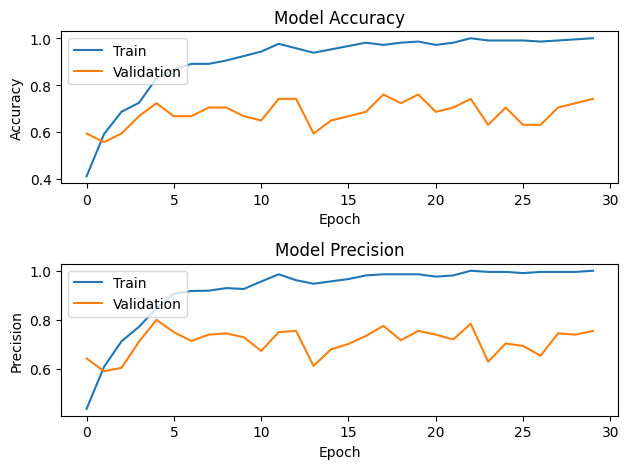

In [ ]:
# `history.history` is a dictionary containing the training and validation metrics
# Plotting accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1 (top subplot)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting precision
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2 (bottom subplot)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust subplot layout to avoid overlap

# Show plot
plt.show()

In [ ]:
# Save the model in HDF5 file
model.save("Emotions_from_images_model.h5")

In [ ]:
def emotion_detector(img_path):
    # Convert the numpy array to a PIL Image object
    img = Image.open(img_path)

    # Convert grayscale image to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize the image to match the model's expected input size
    img = img.resize((224, 224))

    # Normalize the image data
    img_array = np.array(img) / 255.0

    # Expand the dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Use the model to predict
    prediction = model.predict(img_array)
    #return prediction
    # Check if prediction is positive or negative
    if np.argmax(prediction)== 0:
        return 'Angry'
    elif np.argmax(prediction)==1:
       return 'Happy'
    else:
      return 'Sad'



In [ ]:
# Example usage 1
image_path="/content/human-face-emotions/data/valid/Angry/Angry-people-2.jpg"
print(emotion_detector(image_path))

1/1 [==============================] - 1s 622ms/step
Angry


In [ ]:
# Example usage 1
image_path="/content/human-face-emotions/data/valid/Happy/Happy-Guy.jpg"
print(emotion_detector(image_path))

1/1 [==============================] - 0s 60ms/step
Happy


In [ ]:
# Example usage 3
image_path="/content/human-face-emotions/data/valid/Sad/Sad-man-being-consoled-by-friends-in-group-therapy.jpg"
print(emotion_detector(image_path))

1/1 [==============================] - 0s 68ms/step
Sad


In [ ]:
# Define a function suitable for gradio
def gradio_fn(img_array):
    # Convert the numpy array to a PIL Image object
    img = Image.fromarray(np.uint8(img_array))

    # Convert grayscale image to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize the image to match the model's expected input size
    img = img.resize((224, 224))

    # Normalize the image data
    img_array = np.array(img) / 255.0

    # Expand the dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Use the model to predict
    prediction = model.predict(img_array)
    #return prediction
    # Check if prediction is positive or negative
    if np.argmax(prediction)== 0:
        return 'Angry'
    elif np.argmax(prediction)==1:
       return 'Happy'
    else:
      return 'Sad'

In [ ]:
# Define the input component for the Gradio interface
inputs = gr.inputs.Image(shape=(224, 224))

# Define the output component for the Gradio interface
outputs = gr.outputs.Label()

# Create the Gradio interface
gr.Interface(gradio_fn, inputs, outputs, capture_session=True,share=True).launch(debug='True')